# DNABERT (k=3–7) — Coding vs Non-Coding (Pre-wired to your CSV)

Import Data Coding vs Not coding sequences



In [21]:
!wget https://raw.githubusercontent.com/PlantHealth-Analytics/topics_ai/main/Coding_NonCoding_DNA_Sequences


--2025-10-29 17:15:21--  https://raw.githubusercontent.com/PlantHealth-Analytics/topics_ai/main/Coding_NonCoding_DNA_Sequences
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14687733 (14M) [text/plain]
Saving to: ‘Coding_NonCoding_DNA_Sequences’

Coding_NonCoding_DN 100%[===================>]  14.01M  --.-KB/s    in 0.05s   

2025-10-29 17:15:21 (271 MB/s) - ‘Coding_NonCoding_DNA_Sequences’ saved [14687733/14687733]



In [9]:
!pip -q install "transformers>=4.44.0" "datasets>=2.20.0" "accelerate>=0.33.0" "evaluate>=0.4.2" "scikit-learn>=1.3.0" -U
import pandas as pd, numpy as np, re, random, os, matplotlib.pyplot as plt, torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments

LABEL2ID = {"noncoding":0, "coding":1}
ID2LABEL = {0:"noncoding", 1:"coding"}
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


## 1) Choose DNABERT variant

In [10]:
KMER = 6  # 3..7
MODEL_NAME = f"zhihan1996/DNABERT-2-117M"

## 2) Load your file (mapped to expected schema)

In [24]:
PATH = "/content/Coding_NonCoding_DNA_Sequences"
df = pd.read_csv(PATH)

# Map to expected columns
df = df.rename(columns={"DNA_sequence":"sequence", "Target":"label"})
# Normalize labels to 'coding'/'noncoding'
df["label"] = df["label"].map({1:"coding", 0:"noncoding"}).astype(str)

print("Rows:", len(df))
print(df[["sequence","label"]].head(3))
print(df["label"].value_counts())

Rows: 65321
                                            sequence   label
0  CTCTTGCGGTCGATCTGGTCACGGGTGATGGTGAAGGTTACGTAGT...  coding
1  TCGCGGTCCCGAGCCTGATCGTGCGCCGCGCCAACACGACGGTCGA...  coding
2  GGCTACGACGTGACCGCGGGGCAGGTGCTCGTGACCAACGGCGGCA...  coding
label
noncoding    45603
coding       19718
Name: count, dtype: int64


## 3) K-merize + tokenize

In [12]:
def seq_to_kmers(seq: str, k: int) -> str:
    seq = re.sub(r"[^ACGTN]", "", str(seq).upper())
    return " ".join([seq[i:i+k] for i in range(0, len(seq)-k+1)])

for split in ["sequence","label"]:
    assert split in df.columns
df = df[df["sequence"].str.len() >= KMER+20].reset_index(drop=True)

train_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df["label"])
train_df, val_df  = train_test_split(train_df, test_size=0.15/(1-0.15), random_state=42, stratify=train_df["label"])

for d in (train_df, val_df, test_df):
    d["text"] = d["sequence"].apply(lambda s: seq_to_kmers(s, KMER))
    d["labels"] = d["label"].map(LABEL2ID).astype(int)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
hf = DatasetDict({
    "train": Dataset.from_pandas(train_df[["text","labels"]], preserve_index=False),
    "validation": Dataset.from_pandas(val_df[["text","labels"]], preserve_index=False),
    "test": Dataset.from_pandas(test_df[["text","labels"]], preserve_index=False),
})
def tok_fn(batch): return tokenizer(batch["text"], truncation=True, padding=False, max_length=512)
tokenized = hf.map(tok_fn, batched=True, remove_columns=["text"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/45724 [00:00<?, ? examples/s]

Map:   0%|          | 0/9798 [00:00<?, ? examples/s]

Map:   0%|          | 0/9799 [00:00<?, ? examples/s]

You can search for alternative DNABERT models directly on the Hugging Face Hub [here](https://huggingface.co/models?q=DNABERT).

## 4) Train

In [8]:
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=2, id2label=ID2LABEL, label2id=LABEL2ID)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", pos_label=1, zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

args = TrainingArguments(
    output_dir="dnabert_fixedfile",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.06,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

The repository zhihan1996/DNABERT-2-117M contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/zhihan1996/DNABERT-2-117M .
 You can inspect the repository content at https://hf.co/zhihan1996/DNABERT-2-117M.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.embeddings.position_embeddings.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.1.attention.self.key.bias', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.1.attention.self.query.bias', 'bert.encoder.layer.1.attention.self.query.weight', 'bert.encoder.layer.1.at

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.609900,0.616885,0.698102,0.000000,0.000000,0.000000
2,0.629600,0.617799,0.698102,0.000000,0.000000,0.000000
3,0.582100,0.590887,0.697183,0.455446,0.015551,0.030075


TrainOutput(global_step=17148, training_loss=0.6185998253703312, metrics={'train_runtime': 1005.6259, 'train_samples_per_second': 136.405, 'train_steps_per_second': 17.052, 'total_flos': 2.730868904684232e+16, 'train_loss': 0.6185998253703312, 'epoch': 3.0})

In [16]:
# Get a sample sequence
sample_sequence = df["sequence"].iloc[0]
print(f"Original Sequence: {sample_sequence}\n")

# K-merize the sequence
kmer_sequence = seq_to_kmers(sample_sequence, KMER)
print(f"K-merized Sequence (K={KMER}): {kmer_sequence}\n")

# Tokenize the k-merized sequence
tokenized_output = tokenizer(kmer_sequence, truncation=True, padding=True, max_length=512, return_tensors="pt")
print(f"Tokenized Output:\n{tokenized_output}\n")

# Move tokens to the appropriate device
input_ids = tokenized_output["input_ids"].to(device)
attention_mask = tokenized_output["attention_mask"].to(device)

# Get embeddings from the model
with torch.no_grad():
    # The output of the model includes various components depending on the model architecture.
    # For getting embeddings, we typically look at the hidden states.
    # We need to ensure the model is in evaluation mode
    model.eval()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
    # The last hidden state usually represents the token embeddings
    embeddings = outputs.hidden_states[-1]

print(f"Embeddings shape: {embeddings.shape}")
print(f"Embeddings (first token, first 10 dimensions):\n{embeddings[0, 0, :10]}\n")

Original Sequence: CTCTTGCGGTCGATCTGGTCACGGGTGATGGTGAAGGTTACGTAGTCGGGAGCGCCTTCGCGCGAGACCACGACCTTTACCTGCGTGCCGCGAGGTCCCTTGAGC

K-merized Sequence (K=6): CTCTTG TCTTGC CTTGCG TTGCGG TGCGGT GCGGTC CGGTCG GGTCGA GTCGAT TCGATC CGATCT GATCTG ATCTGG TCTGGT CTGGTC TGGTCA GGTCAC GTCACG TCACGG CACGGG ACGGGT CGGGTG GGGTGA GGTGAT GTGATG TGATGG GATGGT ATGGTG TGGTGA GGTGAA GTGAAG TGAAGG GAAGGT AAGGTT AGGTTA GGTTAC GTTACG TTACGT TACGTA ACGTAG CGTAGT GTAGTC TAGTCG AGTCGG GTCGGG TCGGGA CGGGAG GGGAGC GGAGCG GAGCGC AGCGCC GCGCCT CGCCTT GCCTTC CCTTCG CTTCGC TTCGCG TCGCGC CGCGCG GCGCGA CGCGAG GCGAGA CGAGAC GAGACC AGACCA GACCAC ACCACG CCACGA CACGAC ACGACC CGACCT GACCTT ACCTTT CCTTTA CTTTAC TTTACC TTACCT TACCTG ACCTGC CCTGCG CTGCGT TGCGTG GCGTGC CGTGCC GTGCCG TGCCGC GCCGCG CCGCGA CGCGAG GCGAGG CGAGGT GAGGTC AGGTCC GGTCCC GTCCCT TCCCTT CCCTTG CCTTGA CTTGAG TTGAGC

Tokenized Output:
{'input_ids': tensor([[   1,  149,    7,   47,   19,   29,   19,    7,   10,  247,   11,   72,
            8,  247,   16,   72,  

## Numerical Tokens and Embeddings

After the DNA sequence is k-merized and then tokenized into numerical tokens, these tokens are used as input to the model's embedding layer.

The embedding layer converts each numerical token into a dense vector of numbers called an **embedding**. These embeddings capture meaningful information about the k-mers (or tokenized k-mers) based on the data the model was trained on.

These embedding vectors are then processed by the rest of the model to perform the downstream task, such as classifying coding vs. non-coding sequences.

## 5) Evaluate + Confusion Matrix

Accuracy: 0.6978263088070211
Precision: 0.4838709677419355
Recall: 0.015212981744421906
F1: 0.029498525073746312


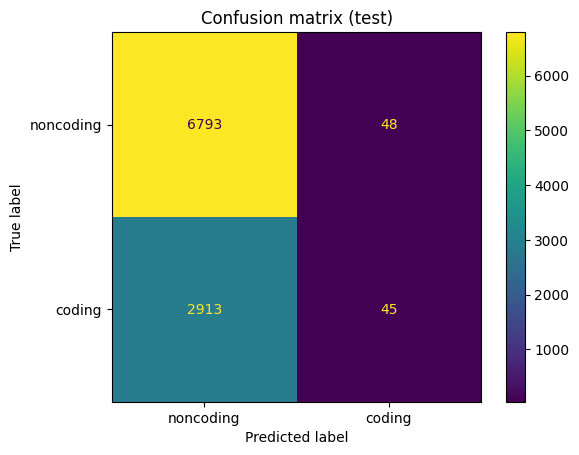

In [17]:
pred = trainer.predict(tokenized["test"])
y_true = pred.label_ids
y_pred = pred.predictions.argmax(-1)
print("Accuracy:", accuracy_score(y_true, y_pred))
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", pos_label=1, zero_division=0)
print("Precision:", prec); print("Recall:", rec); print("F1:", f1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[ID2LABEL[0], ID2LABEL[1]])
disp.plot(); plt.title("Confusion matrix (test)"); plt.show()

## 6) Inference

In [19]:
def predict_sequence(seq: str):
    seq = re.sub(r"[^ACGTN]", "", str(seq).upper())
    text = " ".join([seq[i:i+KMER] for i in range(0, len(seq)-KMER+1)])
    enc = tokenizer([text], truncation=True, padding=True, max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():
        out = trainer.model(**enc).logits.softmax(-1).cpu().numpy()[0]
    return {"coding_prob": float(out[1]), "noncoding_prob": float(out[0]), "prediction": ID2LABEL[int(out.argmax())]}

print(predict_sequence("ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAGATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAGATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAGATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAGATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAG"))

{'coding_prob': 0.2298699915409088, 'noncoding_prob': 0.7701299786567688, 'prediction': 'noncoding'}
